## 1. Cleaning Data

In [74]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import contextily as ctx
from shapely.geometry import Point
import seaborn as sns
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
from esda.moran import Moran
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from zipfile import ZipFile
import os
import shutil
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from pyecharts import Map
import re
import requests
from io import BytesIO

In [75]:
aggregated_votes_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/Aggregated_Votes_By_Borough_And_Party.xlsx'
aggregated_votes_data = pd.read_excel(aggregated_votes_path)

airbnb_listings_path = '/Users/bashir/Documents/UCL/FSDS Github/Airbnb_listings_with_boroughs.csv'
airbnb_listings_data = pd.read_csv(airbnb_listings_path)

tourist_attractions_path = ("/Users/bashir/Documents/UCL/FSDS Github/Modified_Tourist_Attractions_Visits_London.xlsx")
toursit_attractions = pd.read_excel(tourist_attractions_path)

geojson_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/london_boroughs.json'
london_boroughs_geo = gpd.read_file(geojson_path)

london_boroughs_geo = london_boroughs_geo.rename(columns={'name': 'Borough'})

merged_data = london_boroughs_geo.set_index('Borough').join(aggregated_votes_data.set_index('Borough'))
merged_data.reset_index(inplace=True)

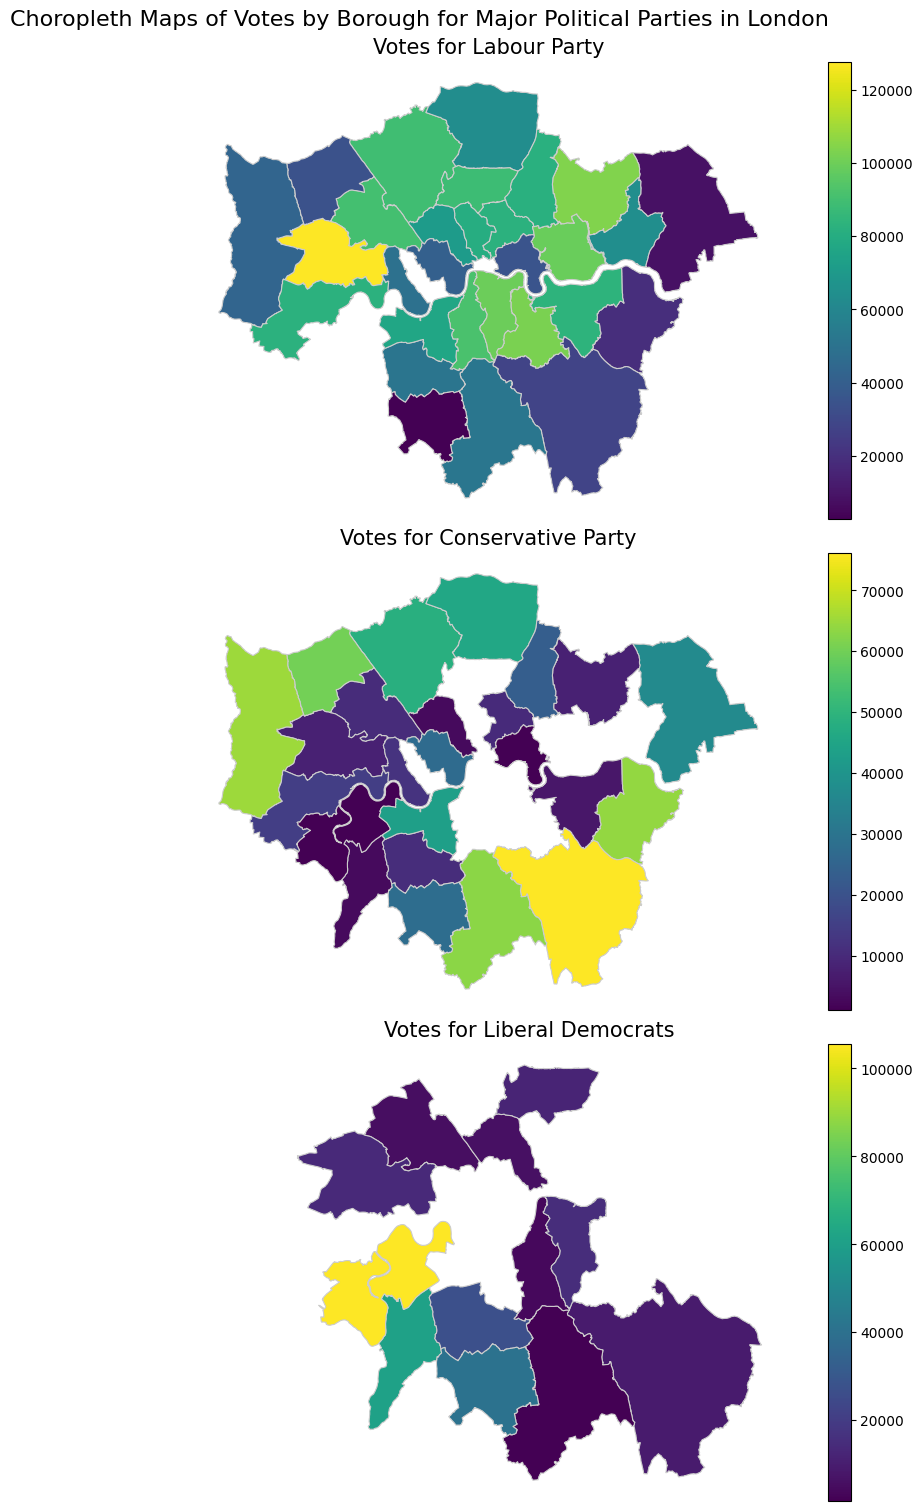

In [76]:
major_parties = aggregated_votes_data['Party name'].value_counts().index[:3]  # Taking top 3 parties

fig, axes = plt.subplots(nrows=len(major_parties), figsize=(10, 15), constrained_layout=True)

for i, party in enumerate(major_parties):
    party_data = merged_data[merged_data['Party name'] == party]

    party_data.plot(column='Votes', cmap='viridis', linewidth=0.8, ax=axes[i], edgecolor='0.8', legend=True)

    axes[i].set_title(f'Votes for {party}', fontdict={'fontsize': '15', 'fontweight' : '3'})
    axes[i].axis('off')

plt.suptitle('Choropleth Maps of Votes by Borough for Major Political Parties in London', fontsize=16)
plt.show()


### 1.2 Airbnb Density

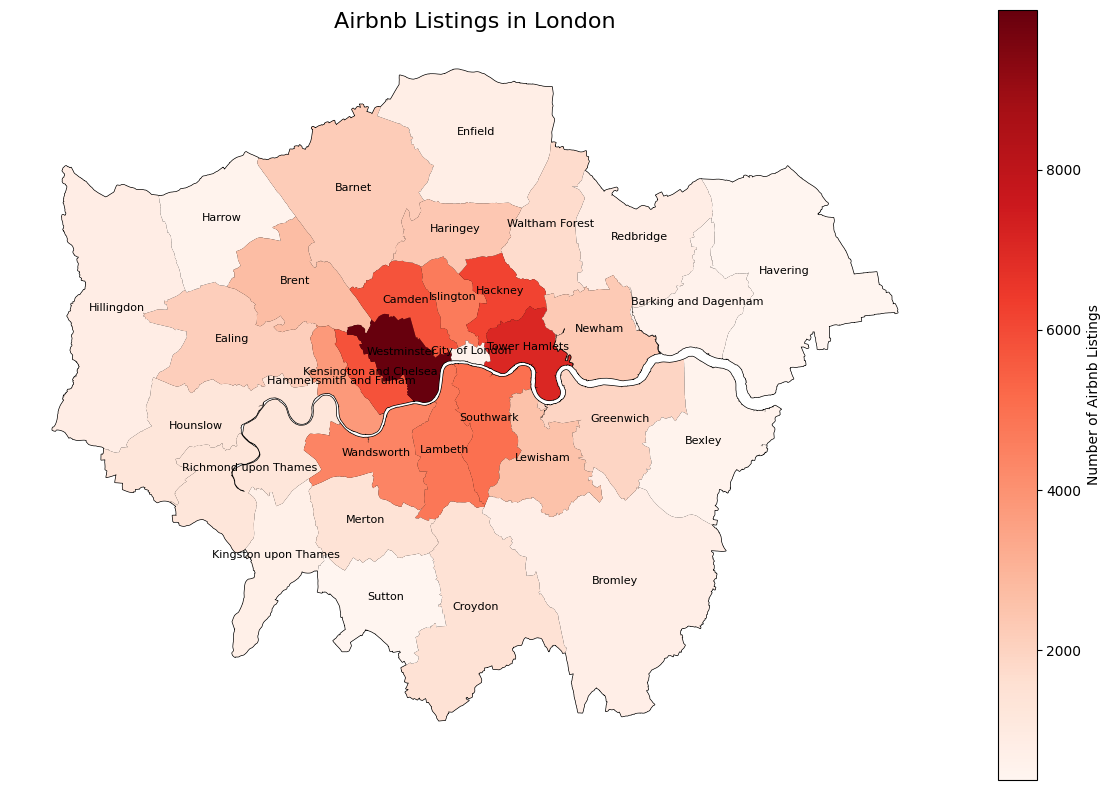

In [77]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

airbnb_listings_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/Airbnb_listings_with_boroughs.csv'
borough_boundaries_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/london_boroughs.json'

airbnb_listings_data = pd.read_csv(airbnb_listings_path)
gdf_airbnb_listings = gpd.GeoDataFrame(
    airbnb_listings_data, 
    geometry=gpd.points_from_xy(airbnb_listings_data.longitude, airbnb_listings_data.latitude)
)

london_boroughs = gpd.read_file(borough_boundaries_path)

airbnb_counts_per_borough = gdf_airbnb_listings['Borough'].value_counts().reset_index()
airbnb_counts_per_borough.columns = ['Borough', 'Count']

london_boroughs = london_boroughs.merge(airbnb_counts_per_borough, how='left', left_on='name', right_on='Borough')
london_boroughs['Count'] = london_boroughs['Count'].fillna(0)  # Fill NaNs with 0

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
london_boroughs.plot(ax=ax, color='white', edgecolor='black')
london_boroughs.plot(ax=ax, column='Count', cmap='Reds', legend=True, 
                     legend_kwds={'label': "Number of Airbnb Listings"})
plt.axis('off')  

for idx, row in london_boroughs.iterrows():
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['name'], 
             horizontalalignment='center', fontdict={'color':'black', 'size': 8})

plt.title("Airbnb Listings in London", fontsize=16)

plt.show()


### 1.3 Graphs

#### 1.3.1 Crime

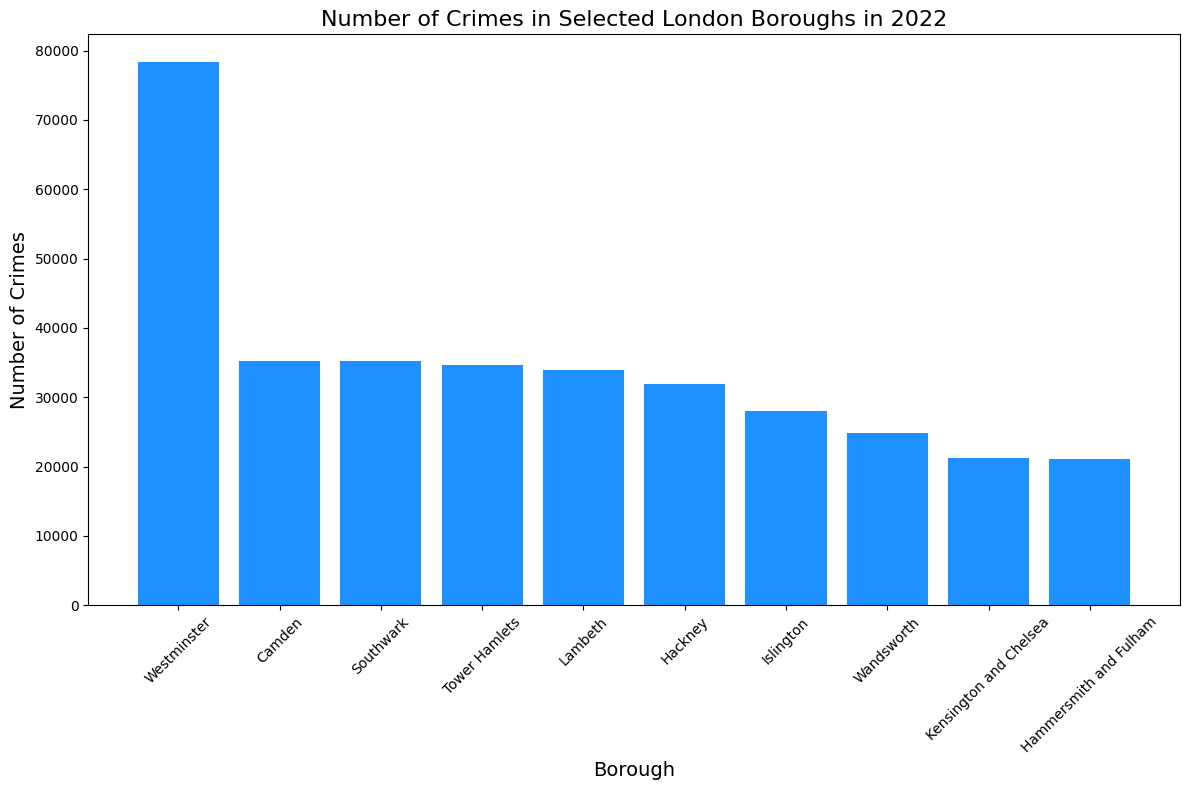

In [78]:
# File path
crime_data_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/Aggregated_Crimes_Per_Borough_Per_Year.csv'

# Load the crime data
crime_data = pd.read_csv(crime_data_path)

# Filter the data for the specified boroughs and the year 2022
selected_boroughs = [
    'Camden', 'Islington', 'Westminster', 'Kensington and Chelsea',
    'Hammersmith and Fulham', 'Tower Hamlets', 'Wandsworth', 'Southwark',
    'Hackney', 'Lambeth'
]
crime_data_selected_boroughs = crime_data[(crime_data['Borough'].isin(selected_boroughs)) & (crime_data['Year'] == 2022)]

# Sort the data for the selected boroughs
crime_data_selected_boroughs_sorted = crime_data_selected_boroughs.sort_values('Crimes', ascending=False)

# Plotting the bar graph for the selected boroughs
plt.figure(figsize=(12, 8))
plt.bar(crime_data_selected_boroughs_sorted['Borough'], crime_data_selected_boroughs_sorted['Crimes'], color='dodgerblue')
plt.title('Number of Crimes in Selected London Boroughs in 2022', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


#### 1.3.2 Income

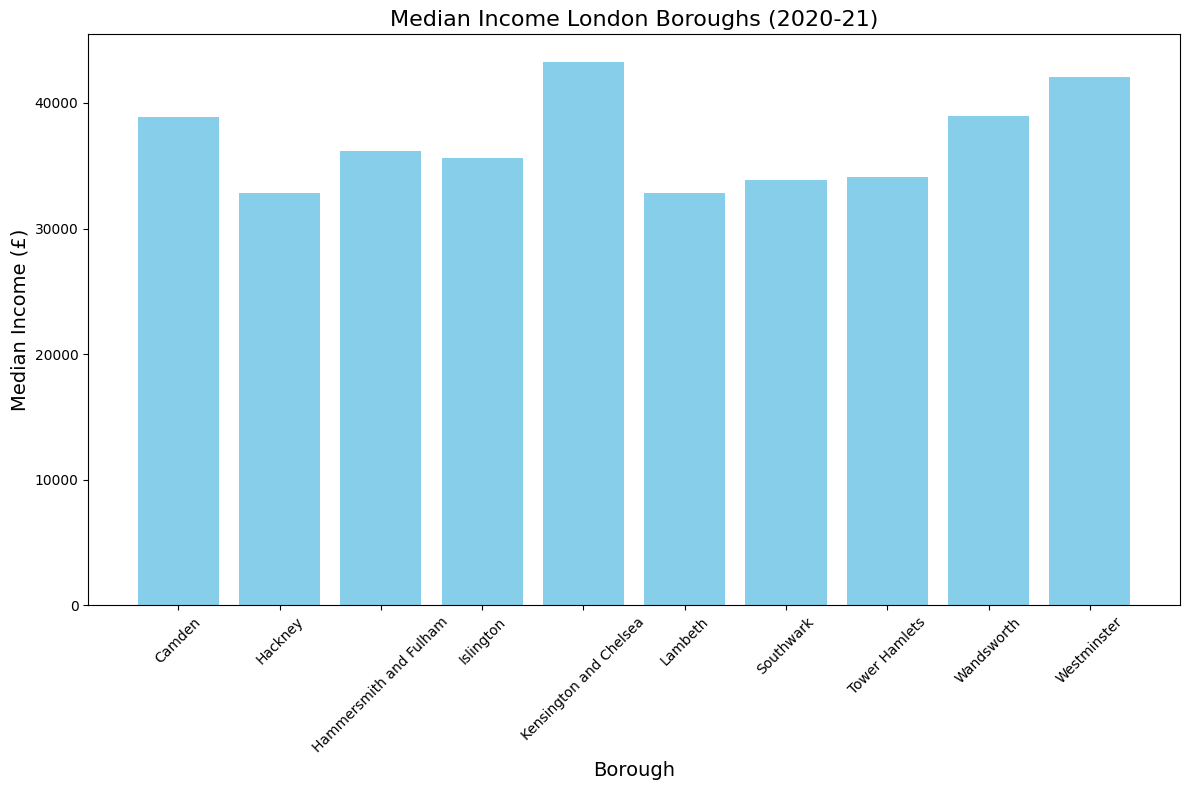

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

income_data_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/income-of-tax-payers.xlsx'

income_data = pd.read_excel(income_data_path, sheet_name='Total Income')

income_sheet = income_data.drop([0, 1]).rename(columns={
    'Unnamed: 0': 'Area',
    '2020-21': 'Number of Individuals',
    'Unnamed: 2': 'Mean £',
    'Unnamed: 3': 'Median £'
})
income_sheet['Median £'] = pd.to_numeric(income_sheet['Median £'], errors='coerce')

selected_boroughs = [
    'Camden', 'Islington', 'Westminster', 'Kensington and Chelsea',
    'Hammersmith and Fulham', 'Tower Hamlets', 'Wandsworth', 'Southwark',
    'Hackney', 'Lambeth'
]
selected_boroughs_income = income_sheet[income_sheet['Area'].isin(selected_boroughs)]

plt.figure(figsize=(12, 8))
plt.bar(selected_boroughs_income['Area'], selected_boroughs_income['Median £'], color='skyblue')
plt.title('Median Income London Boroughs (2020-21)', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Median Income (£)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/t6/2l4skldj33v76fg1nxfgvs7c0000gn/T/ipykernel_39839/989980498.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_median_incomes['London Median Income'] = london_median_income


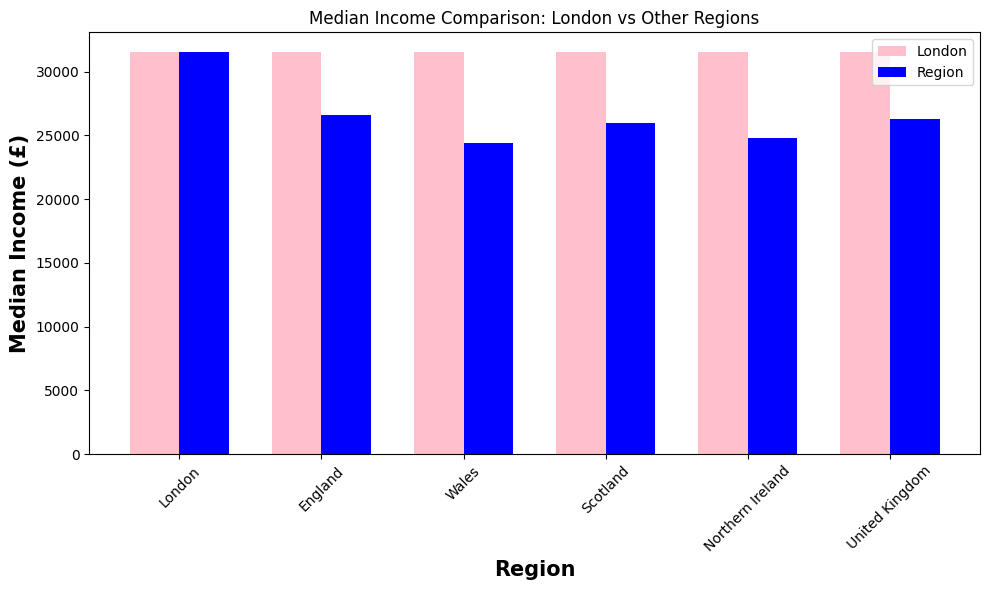

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/income-of-tax-payers.xlsx'
income_data = pd.read_excel(file_path, skiprows=1)

income_data.columns = ['Area', 'Number of Individuals', 'Mean Income', 'Median Income']

region_median_incomes = income_data[income_data['Area'].isin(['London', 'England', 'Wales', 'Northern Ireland', 'Scotland', 'United Kingdom'])]

london_median_income = region_median_incomes[region_median_incomes['Area'] == 'London']['Median Income'].values[0]
region_median_incomes['London Median Income'] = london_median_income

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(region_median_incomes))
pink_bar = ax.bar(index, region_median_incomes['London Median Income'], bar_width, label='London', color='pink')
blue_bar = ax.bar(index + bar_width, region_median_incomes['Median Income'], bar_width, label='Region', color='blue')

ax.set_xlabel('Region', fontweight='bold', fontsize=15)
ax.set_ylabel('Median Income (£)', fontweight='bold', fontsize=15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(region_median_incomes['Area'], rotation=45)
ax.legend()

plt.title('Median Income Comparison: London vs Other Regions')
plt.tight_layout()
plt.show()


## 1.4 Map of attractions

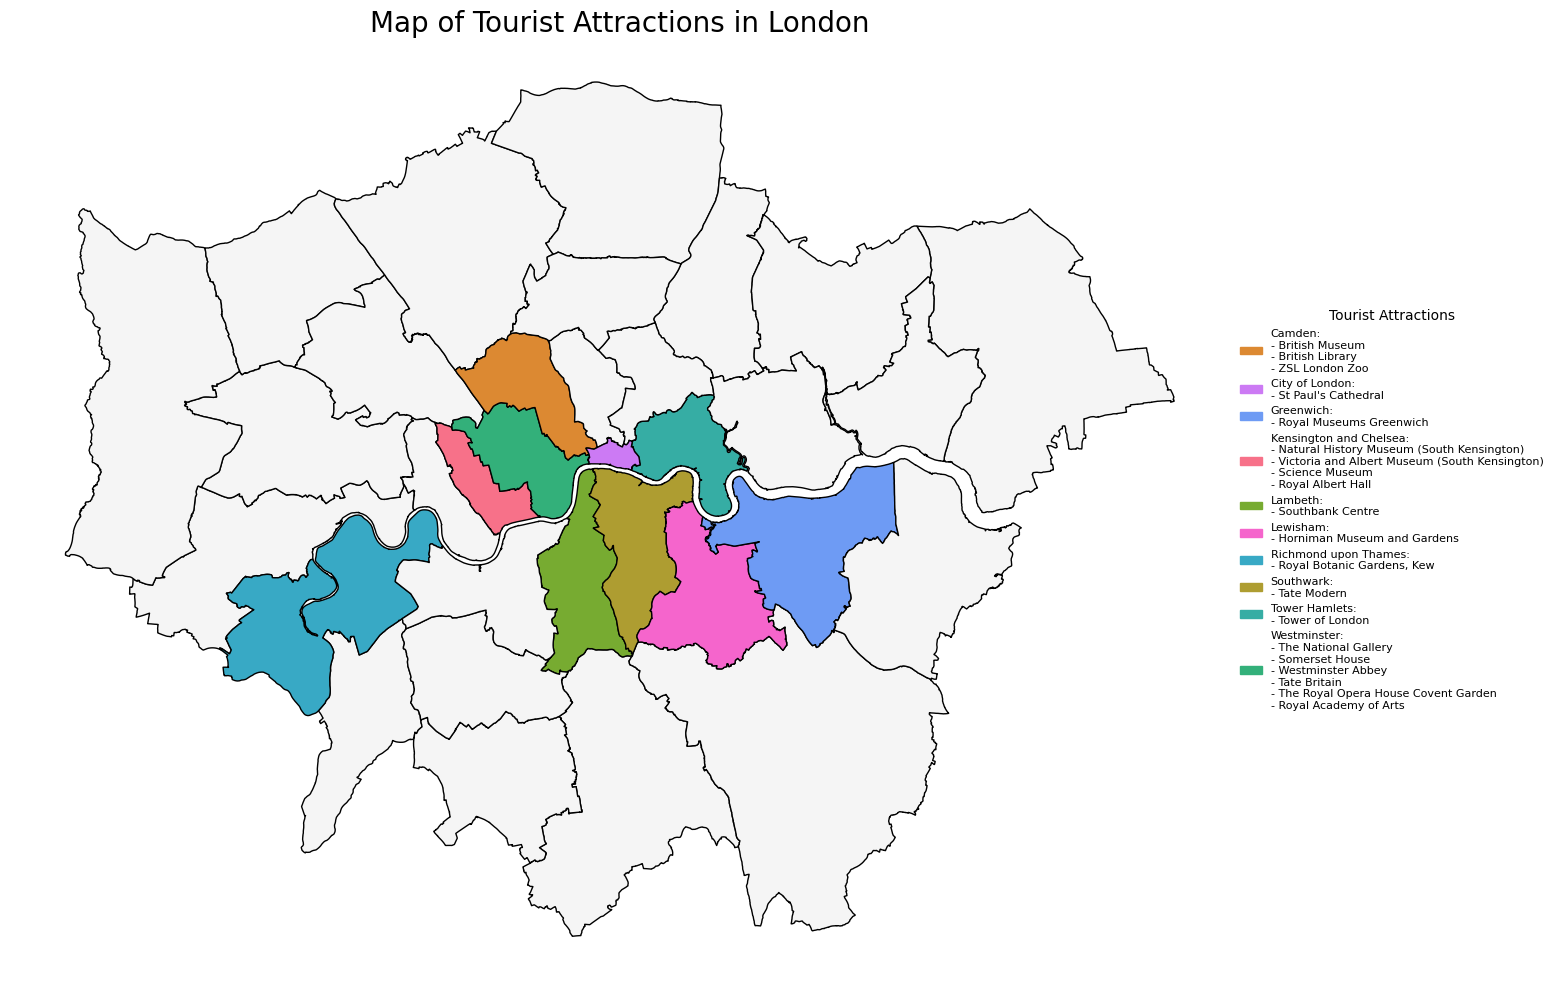

In [81]:
# Assign a unique color to each borough with tourist attractions
unique_boroughs = toursit_attractions['Borough'].unique()
borough_color_palette = sns.color_palette("husl", len(unique_boroughs)).as_hex()
borough_attraction_color_map = {borough: color for borough, color in zip(unique_boroughs, borough_color_palette)}

# Update borough colors in the GeoDataFrame
london_boroughs['color'] = london_boroughs['name'].map(borough_attraction_color_map).fillna('whitesmoke')

# Create the map with updated colors
fig, ax = plt.subplots(figsize=(15, 10))
london_boroughs.plot(ax=ax, color=london_boroughs['color'], edgecolor='black')

# Set title and remove axis
ax.set_title('Map of Tourist Attractions in London', fontsize=20)
ax.axis('off')

# Create a legend for the tourist attractions with a color shade for each borough
legend_entries = []
for borough, attractions in toursit_attractions.groupby('Borough')['Attraction']:
    label_text = f"{borough}:\n" + "\n".join(f"- {attraction}" for attraction in attractions)
    color = borough_attraction_color_map[borough]
    patch = mpatches.Patch(color=color, label=label_text)
    legend_entries.append(patch)

# Place the legend outside the map
legend = ax.legend(handles=legend_entries, loc='center left', bbox_to_anchor=(1, 0.5), title='Tourist Attractions', frameon=False, fontsize=8)
legend.get_title().set_fontsize('10')

plt.tight_layout()
plt.show()


In [82]:
import pandas as pd

# Load the Data
airbnb_listings_path = '/Users/bashir/Documents/UCL/FSDS Github/Airbnb_listings_with_boroughs.csv'
airbnb_listings_data = pd.read_csv(airbnb_listings_path)

tourist_attractions_path = '/Users/bashir/Documents/UCL/FSDS Github/Modified_Tourist_Attractions_Visits_London.xlsx'
tourist_attractions = pd.read_excel(tourist_attractions_path)

# Filter the Airbnb and tourist attractions data for the specified boroughs
boroughs = ["Kensington and Chelsea", "Camden", "Southwark", "Lambeth", "Westminster", 
            "Tower Hamlets", "Richmond upon Thames", "Greenwich", "City of London", "Lewisham"]

airbnb_filtered = airbnb_listings_data[airbnb_listings_data['Borough'].isin(boroughs)]
tourist_filtered = tourist_attractions[tourist_attractions['Borough'].isin(boroughs)]

# Group the Airbnb data by borough and count the number of listings
airbnb_grouped = airbnb_filtered.groupby('Borough').size().reset_index(name='num_airbnb')

# For the tourist attractions, we only consider the visits in 2022
tourist_grouped = tourist_filtered.groupby('Borough')['Visits_2022'].sum().reset_index()

# Merge the Data
merged_data_specific = pd.merge(airbnb_grouped, tourist_grouped, on='Borough', how='inner')

# Data Analysis - Calculating the correlation
correlation_specific = merged_data_specific[['num_airbnb', 'Visits_2022']].corr()

# Display the correlation
print(correlation_specific)


             num_airbnb  Visits_2022
num_airbnb     1.000000     0.678125
Visits_2022    0.678125     1.000000


add under regulation

In [84]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

path1 = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/listings.csv"
airbnb = pd.read_csv(path1)

gdf_airbnb_listings = gpd.GeoDataFrame(
    airbnb, 
    geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude)
)

path2 = "http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/visualisations/neighbourhoods.geojson"
boros = gpd.read_file(path2)

airbnb_counts_per_borough = gdf_airbnb_listings['neighbourhood'].value_counts().reset_index()
airbnb_counts_per_borough.columns = ['neighbourhood', 'Count']

boros = boros.merge(airbnb_counts_per_borough, how='left', left_on='name', right_on='Borough')
boros['Count'] = boros['Count'].fillna(0)  # Fill NaNs with 0

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
boros.plot(ax=ax, color='white', edgecolor='black')
boros.plot(ax=ax, column='Count', cmap='Reds', legend=True, 
                     legend_kwds={'label': "Number of Airbnb Listings"})
plt.axis('off')  

for idx, row in boros.iterrows():
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['name'], 
             horizontalalignment='center', fontdict={'color':'black', 'size': 8})

plt.title("Airbnb Listings in London", fontsize=16)

plt.show()

KeyboardInterrupt: 